# Libon :  Exploratory Data Analysis (v2)
Bruno Seznec 

Data dictionary is 

(copied from the mail)

```users.csv``` : contains user data

User_id


User_registration date

User_country

User_language


```capptain_events.csv``` : contains screen seens / events raised by the application

session_id: 

device_id: a unique identifier associated to the user device

user_id: a unique identifier for a user

application: iphone / android

timestamp: the timestamp when the event / activity was raised

name: The name of the event / activity

extras: additionnal information about the event / activity. It can, for instance, contain the type of pack the user has seen for instance.

type: Activity (screen seen) or event (can be screen seen, button pressed...)

```capptain_sessions.csv```:

session_id

device_id

user_id

application

start_time: when the session started

end_time: when the session ended


____

Schedule

1°) Read the files

Issues : No header line
we add it manually, indicate the pandas command to handle that

events file with some lines not correctly aligned
corrected manually, or by python scrip
indicate some spark processing to handle that

2°) Check the joint between the file with set primitive

are the user_id in users.csv all contained in capptain_sessions.csv and capptain.events.csv ?

3°) on sessions view the session duration , with simple computation
 to have duration with end_time - start_time
 This parameter could be used to a clustering algo. 
 could be a mean to find outliers
 
 on events compute a  sort of basket => collect all the events on the same sessions
 could be a starting point to a basket analysis. : frequent itemset analysis with
 Apriori algo for example.
 It's also a process to find fraud detectio pattern.
 
4°) Sanity checks
For a given user_id, check registration data (from users) < start_time (from sessions)
 

# Import files

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
import time
import datetime
from sets import Set
import matplotlib.pyplot as plt
%matplotlib inline 

In [25]:
# Data visualization library, was quoted in the interview with Fabien Gomez 
import seaborn as sns #

# 1°) Read the files

In [26]:
# the csv files haven't an header line , we added by hand
# could be done by program

# Note :  pandas read_csv option no header line, and column naming afterwards
# read_csv.(......, names=['foo', 'bar', 'baz'], header=None,...)

users = pd.read_csv('./input/users.csv',
                    encoding='utf-8',
                    sep=',')

sessions = pd.read_csv('./input/sessions.csv',
                   encoding='utf-8', 
                   sep=',')

# events csv has an erroneous line with more fields than the other
# at line 24533, but corrected if we add column names
# we restore the last field in suppressing ,\N, if it exists, 
# the last columns is event or activity
# see in the next cell an ad-hoc script to detect erroneous line

# I just correct it manually, to be realistic a small lambda expression with Spark
# could correct the line

events = pd.read_csv('./input/events.csv',
                   encoding='utf-8', 
                   sep=',')

In [27]:
# event file ad-hoc processing
lines = open('./input/events.csv').readlines()
# assuming we have added the header line manually           

#lines = sorted(lines[0:])

for e, line in enumerate( lines ):
        if e == 0:
          print("line", line)
        if e > 0:
            row = line.strip().split(",")
            if len(row) > 8:
                  print ("row = ", len(row), e, line)


('line', 'session_id,device_id,user_id,application,timestamp,name,extras,type\n')


In [28]:
pd.set_option("display.max_columns", 99) # 99 to display all the columns
users.head(10)

,user_id,registration_date,country,language
0,9db90af0a39a5dab4e2311c9f88ad6754137d3be,2016-05-15 07:05:15,FR,fr
1,bc2b5b6626e28ebdde542c0fbbbaf4dea327d95d,2016-05-11 13:20:31,FR,fr
2,fec7b28c8ae985d85913a1bb0e56140ef78d3811,2016-05-13 08:23:17,FR,fr
3,68bf0b6ca42fccc981a47f406e20ef15cb5134bd,2016-05-13 16:24:45,FR,fr
4,4138c789e79d767ec47b7e5ce8a583e9ae901d24,2016-05-13 20:10:05,FR,fr
5,8a54ce928863fbcac425aeacccc145eea8093f37,2016-05-14 11:55:23,FR,fr
6,06fccaf4f378553141e8d7949f87738a38aefa0a,2016-05-12 13:47:25,FR,fr
7,c6ca1cfcd8ce4fe897f709be9dada44f874d672c,2016-05-12 17:23:12,FR,fr
8,9e7ea1ec10368130b74ada1f3082e627506620a8,2016-05-12 21:12:02,FR,fr
9,69c86c44fcfefe3d2446cb99c95387aa5fef638a,2016-05-17 21:58:59,FR,tr


In [29]:
users.describe()
# note in parrallel I use summary() function from R...
# Every users comes from France


,user_id,registration_date,country,language
count,1000,1000,1000,1000
unique,1000,999,1,12
top,c5e75d6be26b082c0fb658bee8b03aca104c4459,2016-05-17 21:44:30,FR,fr
freq,1,2,1000,901


In [30]:
sessions.head(10)

,session_id,device_id,user_id,application,start_time,end_time
0,5035945c0ac144e9ab596f0ad1871b67,7fbafb0f5e4ede5ee58217e8da5e209cc2baea73,4b67330e102350773f346d8c74c983c2bd5d19fe,iphone,2016-05-10 16:32:55.845,2016-05-10 16:33:27.045
1,2a4eab3bd4a34dbd95cfe044b07610b8,7fbafb0f5e4ede5ee58217e8da5e209cc2baea73,4b67330e102350773f346d8c74c983c2bd5d19fe,iphone,2016-05-10 14:50:43.231,2016-05-10 14:53:19.711
2,9f1225493d744ebab48127a59bffd345,5e1e25a8a372e09f028a0660209d48c4bc01a704,2b8582eabdde23b3430ce081a405e275aabf59e2,iphone,2016-05-10 08:39:27.731,2016-05-10 08:41:24.935
3,1fa4878a4dd0462ab43abd436d98eb25,d0f6d8c6e7202752ae58fba4b5ebe0c10f71cdab,57d63e00faedff849d2392c4803cc913a319d4e0,iphone,2016-05-10 10:33:01.703,2016-05-10 10:33:54.338
4,f81cb1af09144f04b96f1069c4555c73,1ab739fa227f1b524d476d37b01da24319e06997,aadf9e4a59dc8f18ba06aea301df456a6c489939,iphone,2016-05-10 21:16:47.891,2016-05-10 21:17:18.105
5,96a8363396ca4dbfb649bd481a8e5498,1ab739fa227f1b524d476d37b01da24319e06997,aadf9e4a59dc8f18ba06aea301df456a6c489939,iphone,2016-05-10 21:08:20.427,2016-05-10 21:11:00.626
6,4d9e71db4c034ff197eae407ca6a5beb,bc5524f8520d207f47532502954a80ab54803e9b,9bc2a97adf506f42341b4596294f4ead468cac91,iphone,2016-05-10 11:02:59.134,2016-05-10 11:03:37.117
7,4d9e71db4c034ff197eae407ca6a5beb,bc5524f8520d207f47532502954a80ab54803e9b,9bc2a97adf506f42341b4596294f4ead468cac91,iphone,2016-05-10 11:02:59.134,2016-05-10 11:03:36.411
8,54d386859b994a57a9c94652ac26caa0,bc5524f8520d207f47532502954a80ab54803e9b,9bc2a97adf506f42341b4596294f4ead468cac91,iphone,2016-05-10 11:09:11.958,2016-05-10 11:13:28.007
9,4d9e71db4c034ff197eae407ca6a5beb,bc5524f8520d207f47532502954a80ab54803e9b,9bc2a97adf506f42341b4596294f4ead468cac91,iphone,2016-05-10 11:02:58.427,2016-05-10 11:03:37.117


In [31]:
sessions.describe()

,session_id,device_id,user_id,application,start_time,end_time
count,11789,11789,11789,11789,11789,11789
unique,10850,978,818,2,10894,10912
top,f77c3202a9664f86bb517a2235cf0198,f672d55ca43a7e8267e5d6063609da4ae873f007,2380478a82376249c39bd9302d550cf20aa42322,android,2016-05-16 10:13:47.832,2016-05-16 10:15:07.205
freq,9,270,294,7292,6,6


In [32]:
events.head(10)

,session_id,device_id,user_id,application,timestamp,name,extras,type
0,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:18:43.487,Sign in,\N,activity
1,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:18:11.291,Welcome - Slideshow,\N,activity
2,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:21:37.523,Register form - Add details,\N,activity
3,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:20:54.526,Register form,\N,activity
4,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:22:35.465,CompadActivity,\N,activity
5,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:24:13.374,Recent - read,\N,activity
6,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:19:28.59,Validate account MSISDN - Automated,\N,activity
7,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:21:27.152,Validate account MSISDN - Automated,\N,activity
8,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:22:05.258,Recent - read,\N,activity
9,01249dc198b0407d8f71cfb642a0f6d4,3bfde5458d6bc822eeea126e523666ee8bd0e40a,7f997a3b7997ac2c172ac09d44c78952f226acfe,android,2016-05-10 22:20:04.211,Validate account MSISDN - Manual,\N,activity


In [33]:
events.describe()
## comment : extra columns almost always \N ?

,session_id,device_id,user_id,application,timestamp,name,extras,type
count,67100,67100,67100,67100,67100,67100,67100,67100
unique,10585,836,817,2,64286,240,60,2
top,f77c3202a9664f86bb517a2235cf0198,f672d55ca43a7e8267e5d6063609da4ae873f007,6348b62d394d40ec46ad26ceecbee190c2d5b6de,android,2016-05-16 10:14:24.824,Recent - read,\N,activity
freq,432,1562,1562,47748,18,8163,66683,40018


# 2°) Check the join

In [34]:
#
users_set = Set([])
for i in range(0,users.shape[0]):
        users_set.add(users.loc[i,'user_id'])
print ("User nb =", len(users_set))

users_sessions_set = Set([])
for i in range(0,sessions.shape[0]):
        users_sessions_set.add(sessions.loc[i,'user_id'])
print ("User nb in sessions =", len(users_sessions_set))

users_events_set = Set([])
for i in range(0,events.shape[0]):
        users_events_set.add(events.loc[i,'user_id'])
print ("User nb in events =", len(users_events_set))

i = 0
for elt in users_set - users_sessions_set:
    i += 1
print ("user - sessions", i)

i = 0
for elt in users_set - users_events_set:
    i += 1
print ("user - events", i)



('User nb =', 1000)
('User nb in sessions =', 818)
('User nb in events =', 817)
('user - sessions', 182)
('user - events', 183)


# 3°) Data distributions

Dataframe ```sessions``` contains start_time and end_time. After a transformation in timestamp datatype, We substract this 2 values. New column ```duration```


Dataframe ```events``` 

joint of ```events``` and ```sessions``` by user_id

Questions :

How many sessions by user ?

Note : This sort of question is better handled with sql queries after simple put the three files in three
disctinct tables with foreign keys. In big data context, it will be easier to denormalize and have only one table.

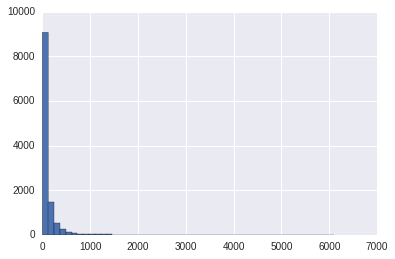

In [35]:
# Compute duration
# Issue : on end_time some values don't contains microseconds
# we just do a quick and dirty try/catch exception

# duration contains seconds time.mktime() return

sessions['duration'] = 0

formats= { "%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S" }

for i in range(0,sessions.shape[0]):
    try:
        time_start = time.mktime(datetime.datetime.strptime(sessions.loc[i,'start_time'], "%Y-%m-%d %H:%M:%S").timetuple())
    except:
        time_start = time.mktime(datetime.datetime.strptime(sessions.loc[i,'start_time'], "%Y-%m-%d %H:%M:%S.%f").timetuple())
    try:
        time_end = time.mktime(datetime.datetime.strptime(sessions.loc[i,'end_time'], "%Y-%m-%d %H:%M:%S.%f").timetuple())
    except :
        time_end = time.mktime(datetime.datetime.strptime(sessions.loc[i,'end_time'], "%Y-%m-%d %H:%M:%S").timetuple())
    sessions.loc[i,'duration'] = time_end - time_start
sessions['duration'].hist(bins=50)
#print (" duration", sorted(sessions['duration'].values))

In [36]:
sessions_events = pd.merge(sessions, events, on='session_id')
print ("sessions_events len", sessions_events.shape)
print ("sessions_events ", sessions_events.loc[2,:])
sessions_events.describe()

('sessions_events len', (81127, 14))
('sessions_events ', session_id               5035945c0ac144e9ab596f0ad1871b67
device_id_x      7fbafb0f5e4ede5ee58217e8da5e209cc2baea73
user_id_x        4b67330e102350773f346d8c74c983c2bd5d19fe
application_x                                      iphone
start_time                        2016-05-10 16:32:55.845
end_time                          2016-05-10 16:33:27.045
duration                                               32
device_id_y      7fbafb0f5e4ede5ee58217e8da5e209cc2baea73
user_id_y        4b67330e102350773f346d8c74c983c2bd5d19fe
application_y                                      iphone
timestamp                         2016-05-10 16:33:22.266
name                                         Contacts-All
extras                                                 \N
type                                             activity
Name: 2, dtype: object)


,duration
count,81127.000000
mean,189.996832
std,291.409480
min,0.000000
25%,51.000000
50%,101.000000
75%,223.000000
max,6107.000000


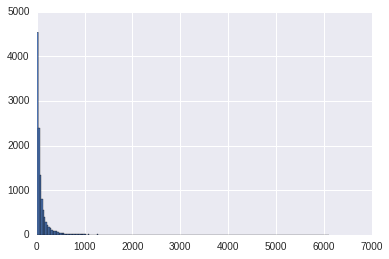

In [37]:
sessions['duration'].hist(bins=200)

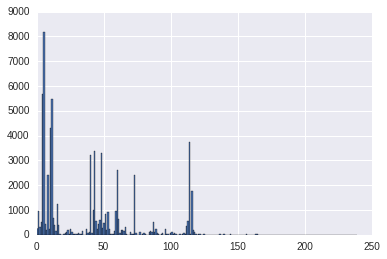

In [39]:
# name contains service name
# we factorize it to have a numerical datatype
events['name'], uniques = pd.factorize(events['name'])
# or LabelEncoder
#for c in feat_cat:
#    le = LabelEncoder()
#    le.fit(train[c])
#    train[c] = le.transform(train[c])

events['name'].hist(bins=240)
#print ("events - name = ", events['name'], uniques)




In [18]:
# This file will contains for later ref. the number associated with the service
pd.DataFrame(uniques).to_csv('index-servicenames.csv',
                          header=['services-names'],
                          sep = ',')

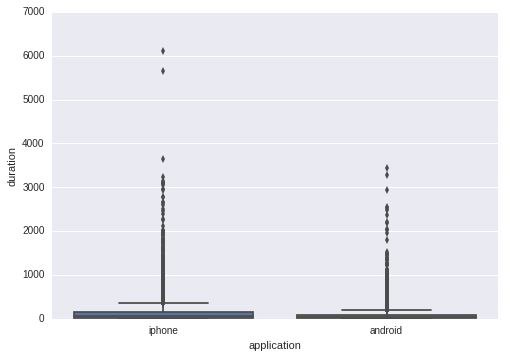

In [19]:
# boxplot duree suivant application
sns.boxplot(y="duration", x="application", data=sessions)
# seems to be a lot of outlier with very high duration value ?

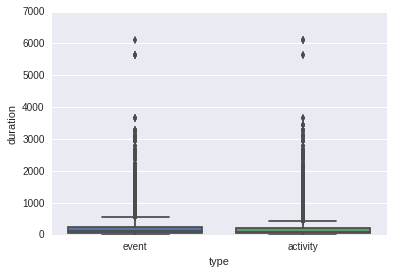

In [40]:
# for session duration, it's better to separate between activity and event
# always a lot of outlier, or long tail distribution
sns.boxplot(y="duration", x="type", data=sessions_events)

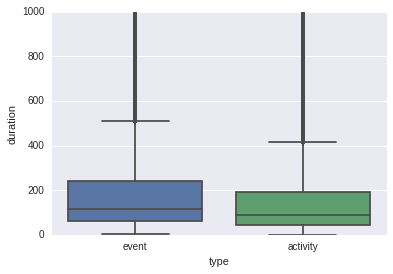

In [41]:
# for session duration, it's better to separate between activity and event
# always a lot of outilier, or long tail distribution
# +filter on duration
df_temp = sessions_events[sessions_events.duration<1000]

sns.boxplot(y="duration", x="type", data=df_temp)

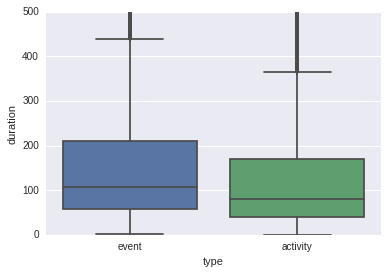

In [42]:
# for session duration, it's better to separate between activity and event
# always a lot of outilier, or long tail distribution
# +filter on duration
df_temp = sessions_events[sessions_events.duration<500]
sns.boxplot(y="duration", x="type", data=df_temp)

# 3.1 Clustering analysis

### k-means simple computation

To be correlated/validated with the business team, as it's an unsupervised algorithm.

In [23]:
# K-means
from sklearn.cluster import KMeans

# Need to investigate n_clusters that give the best compromise
# "elbow trick" in the curve ( total square dist / n_clusters)
#
k_means = KMeans(init='k-means++', n_clusters=10, n_init=50)


X  = sessions_events[['duration','name']].values

print("X = , shape", X, X.shape)



k_means.fit(X)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)

print("k-means center", k_means_cluster_centers)
print("k-means-labels", k_means_labels )

('X = , shape', array([[  32.,   40.],
       [  32.,   10.],
       [  32.,  116.],
       ..., 
       [  12.,    4.],
       [  43.,   11.],
       [  43.,    4.]]), (81127, 2))
('k-means center', array([[   54.79795145,    22.4100463 ],
       [ 1353.30248619,    51.6878453 ],
       [  488.02128022,    39.26149132],
       [ 3062.90821256,    64.60869565],
       [  294.56441951,    40.5998859 ],
       [  162.22728275,    36.19116674],
       [  844.70871449,    48.83196919],
       [ 5849.375     ,    66.        ],
       [ 2130.33333333,    45.79487179],
       [   56.08808494,   106.30135011]]))
('k-means-labels', array([0, 0, 9, ..., 0, 0, 0], dtype=int32))


('my-members =', array([ True,  True, False, ...,  True,  True,  True], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))
('my-members =', array([False, False, False, ..., False, False, False], dtype=bool))


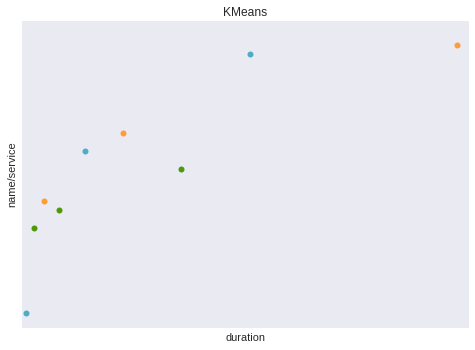

In [24]:
# Plot result

fig = plt.figure(1)
#fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06','#4EACC5', '#FF9C34', '#4E9A06','#4EACC5', '#FF9C34', '#4E9A06']
n_clusters = 10

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.


# KMeans
ax = fig.add_subplot(1,1,1)
for k, col in zip(range(n_clusters), colors):
   # my_members = k_means_labels 
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    print ("my-members =", my_members)
 #   ax.plot(X[my_members, 0], X[my_members, 1], 'w',
 #           markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
ax.set_xlabel('duration')
ax.set_ylabel('name/service')
#plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
#    t_batch, k_means.inertia_))


# 3.2 "basket analysis"

For a given session try to assemble the different events (name column) in a same "basket". In order to get
 a frequent pattern analysis.
 
We will use Apriori algorithm which is well known.
 


In [48]:
# full scan of sessions and events dataframe
# or use the joint between the 2 dataframes
baskets = pd.DataFrame()
baskets_dict = {}
# Dictionary with session_id as key , and string 2,4,70 as name factor value,
# so we can launch Apriori on this structure
# we factorize it to have a numerical datatype
sessions_events['name'], uniques = pd.factorize(sessions_events['name'])
i=0
tmp_str = ""
for line in range(sessions_events.shape[0]):
    
    if  sessions_events.loc[line,'session_id'] not in baskets_dict.keys():
        baskets_dict[sessions_events.loc[line,'session_id']]= " "+`sessions_events.loc[line,'name']`
        if i%100 == 0:
            print("basket item =  ", baskets_dict[sessions_events.loc[line,'session_id']])
    else:
        tmp_str = baskets_dict[sessions_events.loc[line,'session_id']]
        tmp2_str = sessions_events.loc[line,'name']
        tmp3_str = tmp_str+","+`tmp2_str`
        baskets_dict[sessions_events.loc[line,'session_id']] = tmp3_str
        
    i += 1
print("i =",i)


print("baskets_dict", baskets_dict)

 ('basket item =  ', ' 0')
('basket item =  ', ' 29')
('basket item =  ', ' 10')
('basket item =  ', ' 3')
('basket item =  ', ' 105')
('basket item =  ', ' 65')
('basket item =  ', ' 71')
('basket item =  ', ' 85')
('basket item =  ', ' 1')
('basket item =  ', ' 64')
('basket item =  ', ' 66')
('basket item =  ', ' 65')
('basket item =  ', ' 74')
('basket item =  ', ' 108')
('basket item =  ', ' 65')
('basket item =  ', ' 111')
('basket item =  ', ' 65')
('basket item =  ', ' 65')
('basket item =  ', ' 64')
('basket item =  ', ' 65')
('basket item =  ', ' 15')
('basket item =  ', ' 7')
('basket item =  ', ' 15')
('basket item =  ', ' 3')
('basket item =  ', ' 2')
('basket item =  ', ' 2')
('basket item =  ', ' 2')
('basket item =  ', ' 15')
('basket item =  ', ' 10')
('basket item =  ', ' 10')
('basket item =  ', ' 105')
('basket item =  ', ' 105')
('basket item =  ', ' 81')
('basket item =  ', ' 66')
('basket item =  ', ' 8')
('basket item =  ', ' 8')
('basket item =  ', ' 10')
('bas

In [49]:
# Apriori code from ML in Action (Manning edition)

# with Spark , FP-growth is implemented
# https://spark.apache.org/docs/latest/mllib-frequent-pattern-mining.html


def loadDataSet():
    return [[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], [2, 5]]

def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
                
    C1.sort()
    return map(frozenset, C1)#use frozen set so we
                            #can use it as a key in a dict    
    
def scanD(D, Ck, minSupport):
    ssCnt = {}
    for tid in D:
        for can in Ck:
            if can.issubset(tid):
                if not ssCnt.has_key(can): ssCnt[can]=1
                else: ssCnt[can] += 1
    numItems = float(len(D))
    retList = []
    supportData = {}
    for key in ssCnt:
        support = ssCnt[key]/numItems
        if support >= minSupport:
            retList.insert(0,key)
        supportData[key] = support
    return retList, supportData

def aprioriGen(Lk, k): #creates Ck
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i+1, lenLk): 
            L1 = list(Lk[i])[:k-2]; L2 = list(Lk[j])[:k-2]
            L1.sort(); L2.sort()
            if L1==L2: #if first k-2 elements are equal
                retList.append(Lk[i] | Lk[j]) #set union
    return retList


def apriori(dataSet, minSupport = 0.5):
    C1 = createC1(dataSet)
    D = map(set, dataSet)
    L1, supportData = scanD(D, C1, minSupport)
    L = [L1]
    k = 2
    while (len(L[k-2]) > 0):
        Ck = aprioriGen(L[k-2], k)
        Lk, supK = scanD(D, Ck, minSupport)#scan DB to get Lk
        supportData.update(supK)
        L.append(Lk)
        k += 1
    return L, supportData


In [52]:
Dataset=loadDataSet()
Dataset

[[1, 3, 4], [2, 3, 5], [1, 2, 3, 5], [2, 5]]

In [59]:
C1=createC1(Dataset)
C1
D=map( Set , Dataset)
D


[Set([1, 3, 4]), Set([2, 3, 5]), Set([1, 2, 3, 5]), Set([2, 5])]

In [67]:
L1,suppData0=scanD(D, C1, 0.3)
L1

[frozenset({1}), frozenset({3}), frozenset({2}), frozenset({5})]

In [68]:
L,suppData=apriori(Dataset)
L

[[frozenset({1}), frozenset({3}), frozenset({2}), frozenset({5})],
 [frozenset({1, 3}), frozenset({2, 5}), frozenset({2, 3}), frozenset({3, 5})],
 [frozenset({2, 3, 5})],
 []]

In [77]:
# Dataset Libon , must be a list of list
Dataset_Libon = []
i=0
for  k, v in baskets_dict.items():
    i += 1
    # transform string with all number in a list of number
    # there is duplicated elements, will disappear after the Set operator mapping
    row = v.strip().split(",")
    Dataset_Libon.append(list(row))
    if i == 1000:
        break
print ("Big Dataset =",Dataset_Libon)

('Big Dataset =', [['71', '65', '71', '65', '64', '92', '69', '66', '122', '105', '122'], ['70', '90', '70', '64', '71'], ['64', '71', '64', '116', '71', '65', '66', '69', '105'], ['64'], ['64'], ['66', '66', '69', '69', '68', '68', '1', '1', '64', '64', '66', '66', '69', '69', '68', '68', '1', '1', '64', '64'], ['65'], ['71'], ['1', '127', '65', '64', '65'], ['10'], ['115', '68', '69', '66'], ['96', '101', '65', '95', '71', '65', '71', '64', '92', '111', '85', '69', '105', '23', '97', '46', '66', '93'], ['101', '96', '95', '101', '95', '1', '65', '92', '64', '65', '1', '92', '64', '1', '38', '93', '91', '230', '100', '69', '66', '69', '66', '67', '91', '97', '231'], ['65', '65', '111', '65', '8', '1', '1', '65', '67', '84', '85', '112', '67'], ['3', '0', '15'], ['10', '8', '3', '1'], ['64', '1', '64', '68', '69', '66'], ['1', '1', '1', '1', '1', '1', '1', '1', '3', '3', '3', '3', '3', '3', '3', '3', '1', '1', '1', '1', '1', '1', '1', '1', '3', '3', '3', '3', '3', '3', '3', '3', '1', '

In [82]:
C2=createC1(Dataset_Libon)
#L,suppData=apriori(Dataset_Libon)
C2

[frozenset({'0'}),
 frozenset({'1'}),
 frozenset({'10'}),
 frozenset({'100'}),
 frozenset({'101'}),
 frozenset({'102'}),
 frozenset({'103'}),
 frozenset({'104'}),
 frozenset({'105'}),
 frozenset({'106'}),
 frozenset({'107'}),
 frozenset({'108'}),
 frozenset({'109'}),
 frozenset({'11'}),
 frozenset({'110'}),
 frozenset({'111'}),
 frozenset({'112'}),
 frozenset({'113'}),
 frozenset({'114'}),
 frozenset({'115'}),
 frozenset({'116'}),
 frozenset({'117'}),
 frozenset({'118'}),
 frozenset({'119'}),
 frozenset({'12'}),
 frozenset({'120'}),
 frozenset({'121'}),
 frozenset({'122'}),
 frozenset({'123'}),
 frozenset({'124'}),
 frozenset({'125'}),
 frozenset({'126'}),
 frozenset({'127'}),
 frozenset({'129'}),
 frozenset({'13'}),
 frozenset({'131'}),
 frozenset({'133'}),
 frozenset({'134'}),
 frozenset({'135'}),
 frozenset({'136'}),
 frozenset({'137'}),
 frozenset({'138'}),
 frozenset({'139'}),
 frozenset({'14'}),
 frozenset({'140'}),
 frozenset({'141'}),
 frozenset({'142'}),
 frozenset({'148'}),
 

In [83]:
D=map( Set , Dataset_Libon)
D

[Set(['71', '122', '64', '65', '66', '69', '92', '105']),
 Set(['90', '64', '71', '70']),
 Set(['71', '116', '64', '65', '66', '69', '105']),
 Set(['64']),
 Set(['64']),
 Set(['68', '69', '1', '64', '66']),
 Set(['65']),
 Set(['71']),
 Set(['1', '64', '65', '127']),
 Set(['10']),
 Set(['115', '68', '66', '69']),
 Set(['92', '66', '23', '46', '85', '105', '64', '65', '71', '69', '111', '93', '101', '95', '97', '96']),
 Set(['101', '230', '231', '1', '38', '64', '65', '66', '67', '91', '69', '93', '92', '95', '100', '97', '96']),
 Set(['112', '1', '111', '65', '67', '8', '84', '85']),
 Set(['0', '3', '15']),
 Set(['1', '10', '3', '8']),
 Set(['1', '68', '64', '66', '69']),
 Set(['1', '3']),
 Set(['1', '69', '64', '66', '68']),
 Set(['65']),
 Set(['3', '15']),
 Set(['11', '12', '22', '23', '46', '27', '45', '0', '2', '8']),
 Set(['2']),
 Set(['0', '3', '15']),
 Set(['1', '10', '31', '30', '22']),
 Set(['66', '98', '116', '64', '65', '71', '69', '101', '105']),
 Set(['0', '3', '15', '7', '

In [87]:
L1,suppData0=scanD(D, C2, 0.2)
L1

[frozenset({'1'}),
 frozenset({'69'}),
 frozenset({'3'}),
 frozenset({'71'}),
 frozenset({'65'}),
 frozenset({'64'}),
 frozenset({'66'})]

In [93]:
# need to lower the support to 35% or below
L,suppData=apriori(Dataset_Libon,0.35)
L
# The service name 65 = Account-Profile occurs in 35% of all the sessions (on a sample of 1000 sessions)
# Must be a sort of login ?

[[frozenset({'65'})], []]

In [95]:
# support 10%
L,suppData=apriori(Dataset_Libon,0.1)
L,suppData
# 

([[frozenset({'105'}),
   frozenset({'1'}),
   frozenset({'2'}),
   frozenset({'15'}),
   frozenset({'69'}),
   frozenset({'3'}),
   frozenset({'71'}),
   frozenset({'8'}),
   frozenset({'65'}),
   frozenset({'64'}),
   frozenset({'66'}),
   frozenset({'0'})],
  [frozenset({'0', '3'}),
   frozenset({'65', '69'}),
   frozenset({'66', '69'}),
   frozenset({'65', '66'}),
   frozenset({'105', '71'}),
   frozenset({'0', '15'}),
   frozenset({'64', '66'}),
   frozenset({'15', '3'}),
   frozenset({'105', '64'}),
   frozenset({'64', '69'}),
   frozenset({'64', '65'}),
   frozenset({'105', '69'}),
   frozenset({'69', '71'}),
   frozenset({'65', '71'}),
   frozenset({'105', '66'}),
   frozenset({'66', '71'}),
   frozenset({'64', '71'}),
   frozenset({'105', '65'})],
  [frozenset({'105', '65', '69'}),
   frozenset({'105', '64', '71'}),
   frozenset({'105', '64', '65'}),
   frozenset({'64', '65', '66'}),
   frozenset({'64', '66', '71'}),
   frozenset({'105', '64', '66'}),
   frozenset({'105', '64'

## 4°) Sanity check

For a user_id in events, chech timestamp if after registration data. 

To be done with a parallel spark script.